<a href="https://colab.research.google.com/github/bvchand/Diabetes-detection-in-ICU-patients/blob/main/diabetes_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sqlite3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive/Spring-2021/CMPE-255/CMPE-255_Project/widsdatathon2021'

/content/drive/MyDrive/Spring-2021/CMPE-255/CMPE-255_Project/widsdatathon2021


In [ ]:
data_dict = pd.read_csv("DataDictionaryWiDS2021.csv")

In [ ]:
data_dict

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient un...,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None
2,demographic,age,Years,numeric,The age of the patient on unit admission,None
3,demographic,bmi,kilograms/metres^2,string,The body mass index of the person on unit admi...,21.5
4,demographic,elective_surgery,None,binary,Whether the patient was admitted to the hospit...,0
...,...,...,...,...,...,...
176,APACHE comorbidity,immunosuppression,None,binary,Whether the patient has their immune system su...,1
177,APACHE comorbidity,leukemia,None,binary,Whether the patient has been diagnosed with ac...,1
178,APACHE comorbidity,lymphoma,None,binary,Whether the patient has been diagnosed with no...,1
179,APACHE comorbidity,solid_tumor_with_metastasis,None,binary,Whether the patient has been diagnosed with an...,1


In [ ]:
diabetes_train = pd.read_csv("TrainingWiDS2021.csv")
diabetes_train_copy = diabetes_train.copy(deep=True)

In [ ]:
diabetes_train

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,...,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.450,33.0,...,11.3,11.3,36.9,36.9,1.30,1.30,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.450,7.450,51.0,51.0,54.8,51.000000,37.0,37.0,7.450,7.450,51.0,51.0,51.0,51.0,0,0,0,0,0,0,0,1
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203.0,1206.03,1,0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.390,4.0,...,11.6,11.6,34.0,34.0,1.60,1.10,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.440,7.340,337.0,102.0,342.5,236.666667,36.0,33.0,7.370,7.340,337.0,265.0,337.0,337.0,0,0,0,0,0,0,0,0
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119.0,601.01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130152,130153,164758,7,50.0,29.287256,0,Caucasian,M,175.3,Emergency Department,Accident & Emergency,1109,admit,Cardiac ICU,0.023611,0,90.0,NaN,110.0,104.01,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,5.0,NaN,106.0,NaN,0,120.0,NaN,NaN,NaN,NaN,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
130153,130154,197653,7,79.0,29.653433,0,Caucasian,F,162.6,Direct Admit,Accident & Emergency,1106,admit,MICU,0.009722,0,78.4,3.5,105.0,207.01,0,0,0.7,32.0,1.07,NaN,4.0,6.0,0.0,

In [ ]:
diabetes_train.ethnicity.unique()

array(['Caucasian', nan, 'Hispanic', 'African American', 'Asian',
       'Native American', 'Other/Unknown'], dtype=object)

In [ ]:
diabetes_train.age.describe()

count    125169.000000
mean         61.995103
std          16.822880
min           0.000000
25%          52.000000
50%          64.000000
75%          75.000000
max          89.000000
Name: age, dtype: float64

## Deepa Experimental Code


In [ ]:
diabetes_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,130157.0,65079.000000,37573.233831,1.000000,32540.000000,65079.000000,97618.000000,130157.00000
encounter_id,130157.0,213000.856519,38109.828146,147000.000000,180001.000000,213014.000000,246002.000000,279000.00000
hospital_id,130157.0,106.102131,63.482277,1.000000,49.000000,112.000000,165.000000,204.00000
age,125169.0,61.995103,16.822880,0.000000,52.000000,64.000000,75.000000,89.00000
bmi,125667.0,29.110260,8.262776,14.844926,23.598006,27.564749,32.803127,67.81499
...,...,...,...,...,...,...,...,...
immunosuppression,130157.0,0.025669,0.158146,0.000000,0.000000,0.000000,0.000000,1.00000
leukemia,130157.0,0.007307,0.085166,0.000000,0.000000,0.000000,0.000000,1.00000
lymphoma,130157.0,0.004187,0.064574,0.000000,0.000000,0.000000,0.000000,1.00000
solid_tumor_with_metastasis,130157.0,0.020852,0.142888,0.000000,0.000000,0.000000,0.000000,1.00000


In [ ]:
# look at missing values
missing_count=diabetes_train.isnull().sum()
missing_df = (pd.concat([missing_count,missing_count.div(len(diabetes_train))
                          .rename('Missing percent')],axis = 1)
             .loc[missing_count.ne(0)])
missing_df

#So there are quite a few missing values, use one of the strategies to fix

,0,Missing percent
age,4988,0.038323
bmi,4490,0.034497
ethnicity,1587,0.012193
gender,66,0.000507
height,2077,0.015958
...,...,...
h1_arterial_ph_min,107849,0.828607
h1_arterial_po2_max,107445,0.825503
h1_arterial_po2_min,107445,0.825503
h1_pao2fio2ratio_max,113397,0.871232


In [ ]:
#load the test df
diabetes_test = pd.read_csv("UnlabeledWiDS2021.csv")
diabetes_test_copy = diabetes_test.copy(deep=True)
diabetes_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,10234.0,5117.500000,2954.445661,1.0,2559.25,5117.5,7675.75,10234.000
encounter_id,10234.0,140498.779461,3182.455522,135000.0,137742.25,140503.5,143252.75,146000.000
hospital_id,10234.0,10092.391929,57.008062,10001.0,10043.00,10085.0,10145.00,10199.000
age,10234.0,62.853625,17.851661,18.0,52.00,65.0,76.00,96.000
bmi,9219.0,29.116463,8.342873,14.9,23.70,27.6,32.60,69.944
...,...,...,...,...,...,...,...,...
hepatic_failure,10234.0,0.010064,0.099821,0.0,0.00,0.0,0.00,1.000
immunosuppression,10234.0,0.022572,0.148541,0.0,0.00,0.0,0.00,1.000
leukemia,10234.0,0.006547,0.080651,0.0,0.00,0.0,0.00,1.000
lymphoma,10234.0,0.004104,0.063934,0.0,0.00,0.0,0.00,1.000


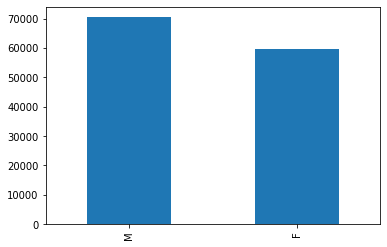

In [ ]:
# drop the unnamed:0 column 
if 'Unnamed: 0' in diabetes_test.columns:
  diabetes_test = diabetes_test.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0' in diabetes_train.columns:
  diabetes_test = diabetes_train.drop(columns=['Unnamed: 0'])

# look at gender distribution
gender = diabetes_train["gender"].value_counts()
gender.plot(kind="bar")

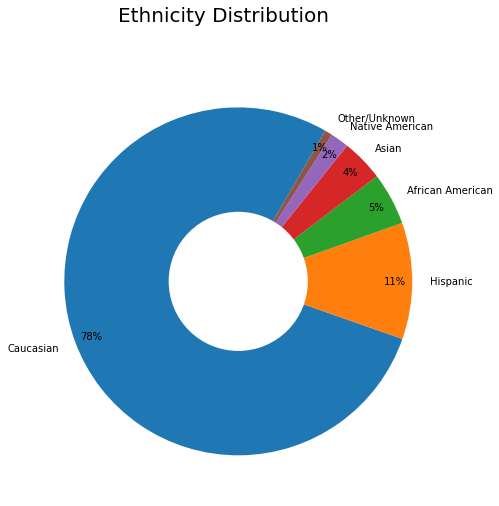

In [ ]:
# look at ethnicity distribution
#diabetes_train['ethnicity'].unique() #to get values for labels
labels = ['Caucasian', 'Hispanic', 'African American', 'Asian',
       'Native American', 'Other/Unknown']
fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Ethnicity Distribution', size = 20)
sizes = diabetes_train["ethnicity"].value_counts()
ax.pie(sizes, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()


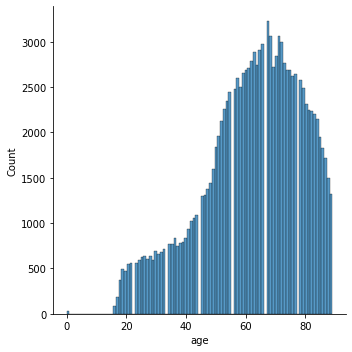

In [ ]:
# look at age distribution
ax = sns.displot(diabetes_train['age']);
# looks like we have some counts against age=0
#most of the patients lie in the 60-80 age range

In [ ]:
sizes

Caucasian           100236
African American     13911
Other/Unknown         6261
Hispanic              5049
Asian                 2198
Native American        915
Name: ethnicity, dtype: int64

## Bharathi - Handling categorical values

In [ ]:
diab_train_df = diabetes_train.loc[:, diabetes_train.columns != 'diabetes_mellitus']
diab_train_target = diabetes_train['diabetes_mellitus']
diab_train_df = diab_train_df.drop(columns='Unnamed: 0')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(diab_train_df, diab_train_target, test_size=0.3, random_state=42)

In [ ]:
rf = RandomForestClassifier()

In [ ]:
diab_train_df.columns

Index(['encounter_id', 'hospital_id', 'age', 'bmi', 'elective_surgery',
       'ethnicity', 'gender', 'height', 'hospital_admit_source',
       'icu_admit_source',
       ...
       'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min',
       'aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis'],
      dtype='object', length=179)

In [ ]:
for cols in diab_train_df.columns:
    if(diab_train_df[cols].dtype == object):
        print("{0} : {1}".format(cols, diab_train_df[cols].dtype))

ethnicity : object
gender : object
hospital_admit_source : object
icu_admit_source : object
icu_stay_type : object
icu_type : object


In [ ]:
diab_train_df[['ethnicity','gender','hospital_admit_source','icu_admit_source','icu_type']]

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_type
0,Caucasian,M,Floor,Floor,CTICU
1,Caucasian,F,Floor,Floor,Med-Surg ICU
2,Caucasian,F,Emergency Department,Accident & Emergency,Med-Surg ICU
3,Caucasian,F,Operating Room,Operating Room / Recovery,CTICU
4,Caucasian,M,NaN,Accident & Emergency,Med-Surg ICU
...,...,...,...,...,...
130152,Caucasian,M,Emergency Department,Accident & Emergency,Cardiac ICU
130153,Caucasian,F,Direct Admit,Accident & Emergency,MICU
130154,African American,M,Emergency Department,Accident & Emergency,Cardiac ICU
130155,Caucasian,M,Emergency Department,Accident & Emergency,Med-Surg ICU


In [ ]:
obj_cols = {'ethnicity','gender','hospital_admit_source','icu_admit_source','icu_type', 'icu_stay_type'}
for col in obj_cols:
    print("{0}: {1}".format(col, diab_train_df[col].unique()))

ethnicity: ['Caucasian' nan 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown']
gender: ['M' 'F' nan]
icu_stay_type: ['admit' 'readmit' 'transfer']
icu_type: ['CTICU' 'Med-Surg ICU' 'CCU-CTICU' 'Neuro ICU' 'MICU' 'SICU'
 'Cardiac ICU' 'CSICU']
icu_admit_source: ['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan]
hospital_admit_source: ['Floor' 'Emergency Department' 'Operating Room' nan 'Direct Admit'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Chest Pain Center' 'Step-Down Unit (SDU)' 'Acute Care/Floor' 'PACU'
 'Observation' 'ICU' 'Other']


#### Handling missing values:



In [ ]:
diab_train_df[['gender']].head()

,gender
0,M
1,F
2,F
3,F
4,M


In [ ]:
diab_train_df['gender'].isnull().sum()

66

In [ ]:
diab_train_df['gender'] = diab_train_df['gender'].fillna(method='ffill')

In [ ]:
diab_train_df['gender'].isnull().sum()

0

In [ ]:
diab_train_df['ethnicity'].isnull().sum()

1587

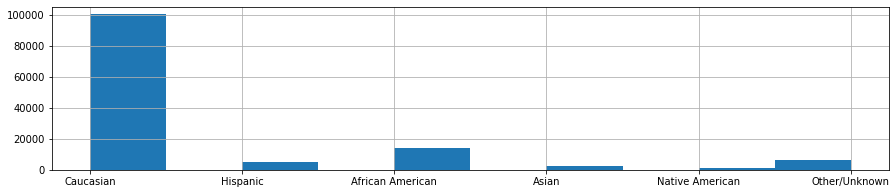

In [ ]:
diab_train_df['ethnicity'].hist(figsize=(15,3))

In [ ]:
diab_train_df['ethnicity'].replace(np.nan, "Unknown", inplace=True)
diab_train_df['ethnicity'].isnull().sum()

0

In [ ]:
diab_train_df['icu_type'].isnull().sum()

0

In [ ]:
diab_train_df['icu_admit_source'].isnull().sum()

240

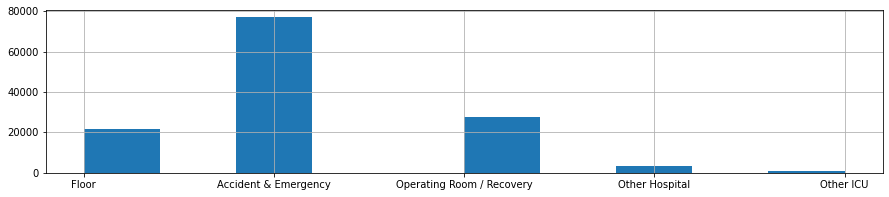

In [ ]:
diab_train_df['icu_admit_source'].hist(figsize=(15,3))

In [ ]:
diab_train_df['icu_admit_source'].replace(np.nan, "Unknown", inplace=True)
diab_train_df['icu_admit_source'].isnull().sum()

0

In [ ]:
diab_train_df['hospital_admit_source'].isnull().sum()

33198

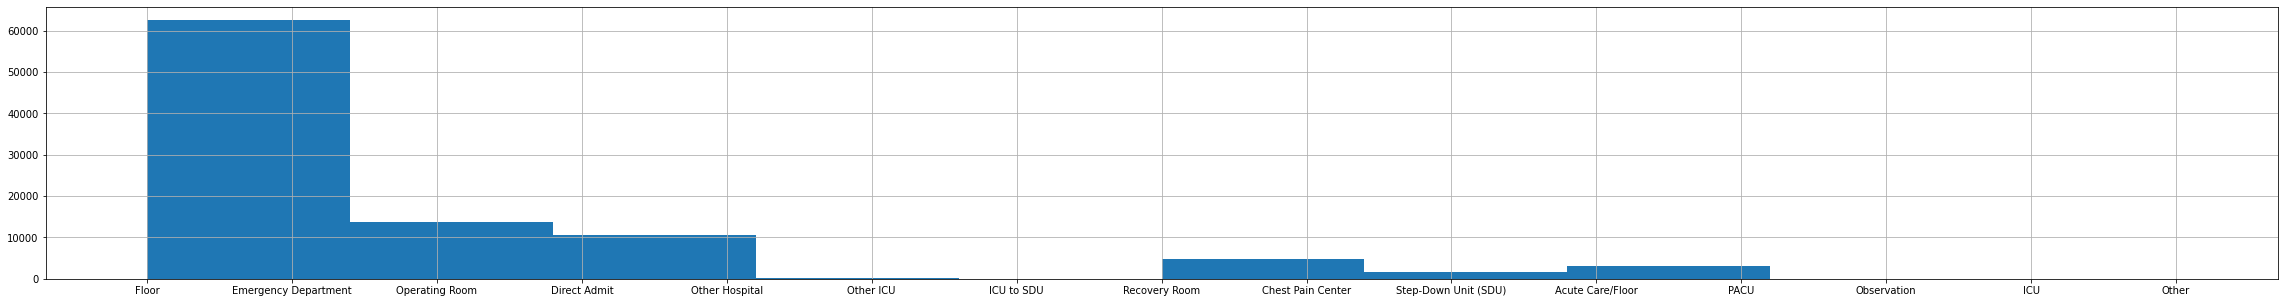

In [ ]:
diab_train_df['hospital_admit_source'].hist(figsize=(40,5))

In [ ]:
diab_train_df['hospital_admit_source'].replace(np.nan, "Unknown", inplace=True)
diab_train_df['hospital_admit_source'].isnull().sum()

0

In [ ]:
diab_train_df['icu_stay_type'].isnull().sum()

0

In [ ]:
for col in obj_cols:
    print("{0}: {1}".format(col, diab_train_df[col].unique()))

ethnicity: ['Caucasian' 'Unknown' 'Hispanic' 'African American' 'Asian'
 'Native American' 'Other/Unknown']
gender: ['M' 'F']
icu_stay_type: ['admit' 'readmit' 'transfer']
icu_type: ['CTICU' 'Med-Surg ICU' 'CCU-CTICU' 'Neuro ICU' 'MICU' 'SICU'
 'Cardiac ICU' 'CSICU']
icu_admit_source: ['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' 'Unknown']
hospital_admit_source: ['Floor' 'Emergency Department' 'Operating Room' 'Unknown' 'Direct Admit'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Chest Pain Center' 'Step-Down Unit (SDU)' 'Acute Care/Floor' 'PACU'
 'Observation' 'ICU' 'Other']


### Encoding categorical features:

In [ ]:
enc = LabelEncoder()
for cols in obj_cols:
    diab_train_df[cols] = enc.fit_transform(diab_train_df[cols])    

In [ ]:
for col in obj_cols:
    print("{0}: {1}".format(col, diab_train_df[col].unique()))

ethnicity: [2 6 3 0 1 4 5]
gender: [1 0]
icu_stay_type: [0 1 2]
icu_type: [2 5 0 6 4 7 3 1]
icu_admit_source: [1 0 2 3 4 5]
hospital_admit_source: [ 4  3  8 15  2 10 11  6 13  1 14  0 12  7  5  9]


### Feature selection using mutual information

In [ ]:
# from sklearn.feature_selection import mutual_info_classif
# threshold = 5  # the number of most relevant features
# high_score_features = []
# feature_scores = mutual_info_classif(diab_train_df, diab_train_target, random_state=0)
# for score, f_name in sorted(zip(feature_scores, diab_train_df.columns), reverse=True)[:threshold]:
#         print(f_name, score)
#         high_score_features.append(f_name)
# diab_train_df_mic = diab_train_df[high_score_features]
# print(diab_train_df_mic.columns)

In [ ]:
missing_count=diab_train_df.isnull().sum()
missing_df = (pd.concat([missing_count.rename('Missing count'),missing_count.div(len(diab_train_df))
            .rename('Missing percent')],axis = 1).loc[missing_count.ne(0)])
missing_df.style.background_gradient(cmap="Blues")

,Missing count,Missing percent
age,4988,0.038323
bmi,4490,0.034497
height,2077,0.015958
weight,3463,0.026606
albumin_apache,78163,0.600529
apache_2_diagnosis,1685,0.012946
apache_3j_diagnosis,865,0.006646
bilirubin_apache,82560,0.634311
bun_apache,25411,0.195233
creatinine_apache,24882,0.191169


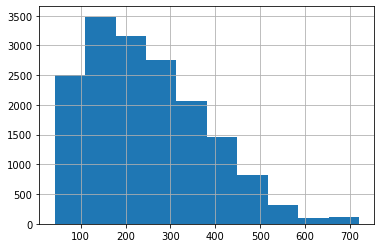

In [ ]:
diab_train_df['h1_pao2fio2ratio_max'].hist()

In [ ]:
diab_train_df['h1_pao2fio2ratio_max'].describe()

count    16760.000000
mean       247.525419
std        131.440167
min         42.000000
25%        144.000000
50%        228.125000
75%        333.000000
max        720.000000
Name: h1_pao2fio2ratio_max, dtype: float64

In [ ]:
diab_train_df['h1_pao2fio2ratio_max'].fillna(method='ffill', inplace=True)

In [ ]:
diab_train_df['h1_pao2fio2ratio_max'].describe()

count    130156.000000
mean        246.967683
std         131.797058
min          42.000000
25%         144.000000
50%         226.000000
75%         334.000000
max         720.000000
Name: h1_pao2fio2ratio_max, dtype: float64

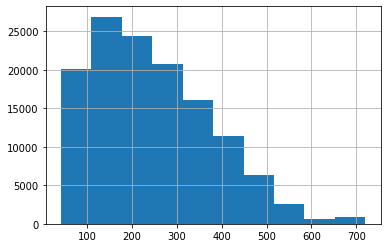

In [ ]:
diab_train_df['h1_pao2fio2ratio_max'].hist()